In [4]:
%pip install numpy pandas matplotlib scikit-learn h5py

You should consider upgrading via the 'c:\Users\yongz\Documents\ICT2211\Nature energy - code\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [48]:
# import h5py
import scipy.io
import scipy.stats
import sklearn.metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# matFilename = './Data/2017-05-12_batchdata_updated_struct_errorcorrect.mat'
# f = h5py.File(matFilename)

In [8]:
# matFilename = './Data/2017-05-12_batchdata_updated_struct_errorcorrect.mat'
# f1 = h5py.File(matFilename)

In [9]:
# matFilename = './Data/2017-06-30_batchdata_updated_struct_errorcorrect.mat'
# f2 = h5py.File(matFilename)

In [3]:
# batch = f['batch']
# list(batch.keys())

['Vdlin',
 'barcode',
 'channel_id',
 'cycle_life',
 'cycles',
 'policy',
 'policy_readable',
 'summary']

In [5]:
# summary = f[batch['summary'][0,0]]
# summary.keys()

<KeysViewHDF5 ['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle']>

In [6]:
# num_cells = batch['summary'].shape[0]
# num_cells

46

In [61]:
featFileName = "./Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)
batch_pd

,policy,barcode,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,3_6C-80PER_3_6C,???,1189,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-4.365945
1,3_6C-80PER_3_6C,???,1178,1.075301,0.009288,1.080630,-1.958457,-2.387257,-5.013960,-0.367163,0.012464,-3.803325,0.000006,1.080945,-0.000041,1.084710,-3.470844
2,3_6C-80PER_3_6C,???,1176,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,0.000011,1.084826,-0.000044,1.089331,-4.832290
3,4C-80PER_4C,???,1225,1.079723,0.006530,1.084750,-1.722149,-2.127507,-4.442613,-0.357486,0.039579,-3.739833,0.000018,1.084053,-0.000003,1.085031,-3.108476
4,4C-80PER_4C,???,1226,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,0.000020,1.081850,-0.000033,1.085851,-3.825199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,6C_31PER_4_25C,???,462,1.073565,0.007075,1.079078,-1.226029,-1.547619,-3.394968,-1.993884,0.134112,-4.417652,0.000013,1.078951,-0.000031,1.082138,-1.422837
76,6C_40PER_4C,???,457,1.070887,0.006366,1.076360,-1.244632,-1.577172,-3.452581,-1.389835,0.111612,-4.012170,0.000023,1.075190,-0.000017,1.078153,-1.778092
77,6C_4PER_4_75C,???,487,1.070473,0.005186,1.073041,-1.361351,-1.680775,-3.688418,-1.539699,0.113010,-4.279524,-0.000006,1.074844,-0.000079,1.080819,-1.564843
78,6C_52PER_3_5C,???,429,1.072614,0.007384,1.079520,-1.219913,-1.521692,-3.368943,-1.205534,0.132095,-4.142284,0.000030,1.077609,-0.000013,1.080783,-3.213435


In [62]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.07068920e+00,  4.68365200e-01,  1.07591260e+00, ...,
         1.09126183e+00,  3.90283333e-05,  1.07207769e+00],
       [ 1.07530120e+00,  9.28830000e-03,  1.08062970e+00, ...,
         1.08094533e+00, -4.06916667e-05,  1.08471002e+00],
       [ 1.07992230e+00,  8.13120000e-03,  1.08494040e+00, ...,
         1.08482585e+00, -4.38450000e-05,  1.08933135e+00],
       ...,
       [ 1.07047260e+00,  5.18560000e-03,  1.07304080e+00, ...,
         1.07484368e+00, -7.90550000e-05,  1.08081930e+00],
       [ 1.07261380e+00,  7.38420000e-03,  1.07951970e+00, ...,
         1.07760921e+00, -1.25166667e-05,  1.08078345e+00],
       [ 1.04213750e+00,  8.11270000e-03,  1.04702290e+00, ...,
         1.04935858e+00, -8.31183333e-05,  1.05527146e+00]])

In [13]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']

## Features

In [7]:
# bat_info = pd.DataFrame(
#     [
#         [str(row), str(row), '???', '???', int(f[batch['cycle_life'][row,0]][0,0])]
#         for row in range(num_cells)
#     ],
#     columns=('battery_id','channel_id','policy','policy_readable','cycle_life'))
# feat = np.zeros([num_cells,13], dtype=np.float32)
# for i in range(num_cells):
#     summary = f[batch['summary'][i,0]]
#     # capacity features
#     feat[i,0] = summary['QDischarge'][0,1]
#     feat[i,1] = max(
#         summary['QDischarge'][0,0:99]
#     ) - feat[i,0]
#     # quoted: "fix data issue"
#     feat[1,1] = 0.0064
#     feat[i,2] = summary['QDischarge'][0,99]

#     # Q features
#     cycles = f[batch['cycles'][i,0]]

#     Q10 = np.hstack((f[cycles['Qdlin'][9,0]]))
#     Q100 = np.hstack((f[cycles['Qdlin'][99,0]]))
#     Qdiff = Q100 - Q10

#     feat[i,3] = np.log10(np.abs(np.min(Qdiff)))
#     feat[i,4] = np.log10(np.abs(np.mean(Qdiff)))
#     feat[i,5] = np.log10(np.abs(np.var(Qdiff)))
#     feat[i,6] = np.log10(np.abs(scipy.stats.skew(Qdiff)))
#     feat[i,7] = np.log10(np.abs(scipy.stats.kurtosis(Qdiff)))
#     feat[i,8] = np.log10(np.abs(Qdiff[0]))

#     # https://stackoverflow.com/questions/46779605/in-the-linearregression-method-in-sklearn-what-exactly-is-the-fit-intercept-par
#     R3 = linear_model.LinearRegression(fit_intercept=True)
#     R3.fit(
#         np.arange(2,100).reshape(-1,1),
#         summary['QDischarge'][0,1:99]
#     )
#     feat[i,9] = R3.coef_[0]
#     feat[i,10] = R3.intercept_

#     R1 = linear_model.LinearRegression(fit_intercept=True)
#     R1.fit(
#         np.arange(91,100).reshape(-1,1),
#         summary['QDischarge'][0,90:99]
#     )
#     feat[i,11] = R1.coef_[0]
#     feat[i,12] = R1.intercept_


In [64]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

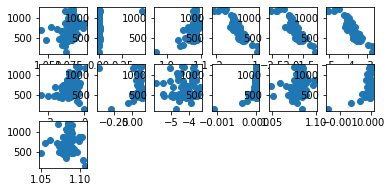

In [65]:
for i in range(feat.shape[1]):
    plt.subplot(4, 6, i+1)
    plt.scatter(feat[:,i], bat_info["cycle_life"])

plt.show()

## Model Building

In [131]:
# randomly partition into train and test
feat_train, feat_test, label_train, label_test = train_test_split(
    feat, bat_info["cycle_life"],
    test_size=0.5
    # the paper split every other cell, resulting in 50-50 mix
)

In [132]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

In [133]:
# train model
# Linear Elastic Net with Four-Fold Cross-Validation, alpha = 0.9
B = linear_model.ElasticNetCV(cv=4, l1_ratio=0.9)
B.fit(feat_train_scaled, label_train)

ElasticNetCV(cv=4, l1_ratio=0.9)

In [134]:
# make predictions
ypred_train = B.predict(feat_train_scaled)
ypred_test = B.predict(feat_test_scaled)

## Evaluation

In [135]:
# calculate prediction interval (incomplete)
print(sklearn.metrics.mean_squared_error(label_train, ypred_train, squared=False))
print(sklearn.metrics.mean_squared_error(label_test, ypred_test, squared=False))

76.17758187899626
100.92499537202322


In [136]:
B.score(feat_train_scaled, label_train)

0.8991885337041086

In [137]:
B.score(feat_test_scaled, label_test)

0.8107991498453933